**PS2: Sampling-based Planning**

Planning Algorithms in AI

Kashirin Aleksandr

Skoltech 2021

**Task 1: Visualization**

For this task, you will write a Python script or notebook, please make sure all your code is well structured and understandable.

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import pickle
from environment import State, ManipulatorEnv
import angle_util
import matplotlib.animation as anim

# Control flags
labelsize = 14
titlesize = 16
suptitlesize = 18

# Define random seed
np.random.seed(0)

**A. Visualize the manipulator in the start state and target state. Comment on your thoughts about comparison the discretized orientation space from PS1 vs continuous orientation space in current problemset.**

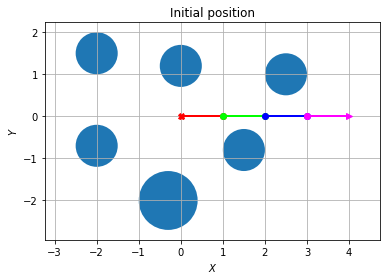

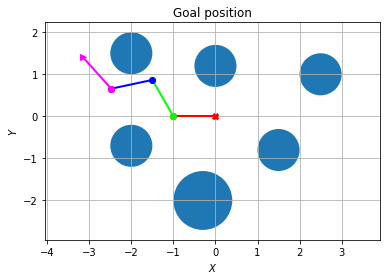

In [2]:
# Read the data from the file
with open("data.pickle", "rb") as handle:
    data = pickle.load(handle)

# Assign the states
start_state = State(np.array(data["start_state"]))
goal_state = State(np.array(data["goal_state"]))

# Calculate environment
env_start = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=start_state,
                                collision_threshold=data["collision_threshold"])
env_goal = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=goal_state,
                                collision_threshold=data["collision_threshold"])

# Render the pictures
env_start.render('Initial position')
env_goal.render('Goal position')
plt.show()


**Comment: Discretized configuration space in PS1 consisted of 3 variables [x, y, $\theta$] and had a size of $100*100*4 = 40000$. Here configuration space consists of 4 variables [$\theta_1$, $\theta_2$, $\theta_3$, $\theta_4$] and each angle is discritized from $(-180, 180]$ with 1 degree step, hence we have a size of configuration space here equal to: $360^4 = 16796160000$. But, if we consider that angle can change continuously in range $(-180, 180]$ than the size of the configuration space tends to infinity.**

**B. Visualize the manipulator in 4 random orientations that include both colliding and non-colliding configurations. Check what does the ManipulatorEnv.check_collision function returns for those configurations. Comment on your observations.**


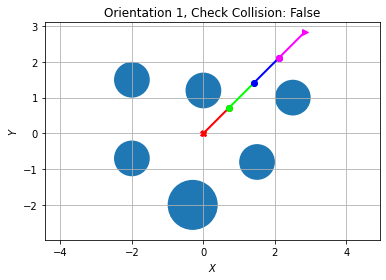

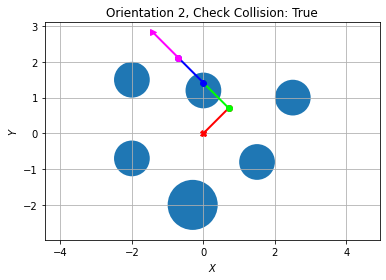

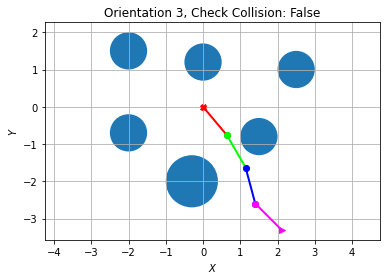

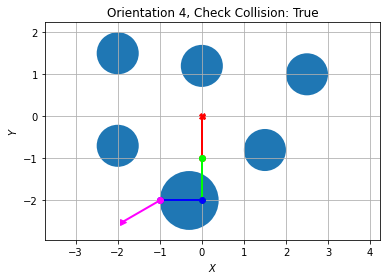

In [3]:
# Define 4 orientations
orient_1 = State(np.array([45, 0, 0, 0]))
orient_2 = State(np.array([45, 90, 0, 0]))
orient_3 = State(np.array([-50, -10, -15, 30]))
orient_4 = State(np.array([-90, 0, -90, 30]))

# Calculate environment
env_orient_1 = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=orient_1,
                                collision_threshold=data["collision_threshold"])
env_orient_2 = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=orient_2,
                                collision_threshold=data["collision_threshold"])
env_orient_3 = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=orient_3,
                                collision_threshold=data["collision_threshold"])
env_orient_4 = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=orient_4,
                                collision_threshold=data["collision_threshold"])                                

# Render the pictures
env_orient_1.render(f'Orientation 1, Check Collision: {env_start.check_collision(orient_1)}')
env_orient_2.render(f'Orientation 2, Check Collision: {env_start.check_collision(orient_2)}')
env_orient_3.render(f'Orientation 3, Check Collision: {env_start.check_collision(orient_3)}')
env_orient_4.render(f'Orientation 4, Check Collision: {env_start.check_collision(orient_4)}')
plt.show()

**Comment: Check Collision is the function that returns True when manipulator is in collision with the environment else False. Degree of each next joint is counted from the previous joint, but not from the frame origin.**

**Task 2: RRT**

For this task, you will implement the RRT algorithm to solve the path planning for the 4R manipulator.

**A: You need to implement the RRT algorithm for agent in continuous domain. The starting configuration of the agent is (0, 0, 0, 0) and the goal configuration is (-180.0, -60.0, 72.0, -60.0)**

In [4]:
# Define function to get distance in C-space
def get_distance(q_1, q_2, weights):
    """ Get L1 Manhattan distance between two vectors of angles

    Args:
        q_1 - vector q_1
        q_2 - vector q_2
        weights - np.array of angle weights

    Returns:
        distance - L1 Manhattan distance between two vectors
    """

    distance = np.linalg.norm(weights * angle_util.angle_difference(q_2, q_1), ord=1)
    
    return distance

# Define sampling function
def sample(target, weight):
    """ Function put sample point in C-space according to the distribution

    Args:
        target - Target position
        weight - weight of the target direction
    Returns:
        q_rand - vector of angles
    """
    # Random uniform + direction towards the target
    q_rand = np.random.uniform(-180, 180, 4) + weight * target.angles
    return q_rand

# Define max_difference in C-space for each joint
max_difference = 10  # L1 norm

In [5]:
# Define RRT (Rapidly-exploring Random Trees) Algorithm
def find_path_RRT(start, target, max_difference=max_difference, env=env_start, N = 3000, weights_angles=np.array([1, 1, 1, 1]), target_radius=30):
    """ Find path plan with RRT (Rapidly-exploring Random Trees) Algorithm

    Args:
        start - Starting position
        target - Target position
        max_difference - Maximum angle distance for each joint
        env - Environment object
        N - Maximum amount of iterations
        weights_angles - np.array of angle weights
        target_radius - Radius of the target node which is reachable from the nearest node
    Returns:
        plan - Path plan, list of tuples of coordinates
    """
    # Initialize parent table {child:parent}
    parent_table = dict()
    # Initialize list of nodes
    nodes = []
    # Initialize starting value in node's list
    nodes.append(start)
    # Initialize successful flag
    flag = False
    # Initialize plan
    plan = 0
    # Initialize iteration counter
    counter = 0

    # RRT Algorithm
    # While solution was not found
    while flag != True:
        # if solution was found
        if flag == True:
            # Then break
            break
        # Increment counter
        counter += 1
        # If counter equals to N
        if counter == N:
            # Then break
            break
        # Put random sample node in the configuration space
        q_rand = sample(target, 0.1)
        # Check if the angles are lie in the given space
        # For each angle in random node
        for i in range(len(q_rand)):
            # if the angle is less than -180
            if q_rand[i] < -180:
                # Then change to 360 - |angle|
                q_rand[i] = 360 - np.abs(q_rand[i])
            # if angle is more than 180
            elif (q_rand[i] >= 180):
                # Then change to -(360 - angle)
                q_rand[i] = -(360 - q_rand[i])
        # Find nearest node
        distance_to_nodes = dict()
        # For each node in list of nodes
        for node in nodes:
            # Calculate distance between q_rand and current node
            distance_to_nodes[node] = get_distance(q_rand, node.angles, weights=weights_angles)
        # Find minimum distance among all distances and assign it with the mearest node
        nearest_node = min(distance_to_nodes, key=distance_to_nodes.get)
        # Find distance between random node and another nearest node
        angle_differences = angle_util.angle_difference(q_rand, nearest_node.angles)
        # Get the max found deviation among angle differences between random node and the nearest node
        max_found_deviation = np.max(np.abs(angle_differences))
        # Get the number of steps
        n_steps = int(np.ceil(max_found_deviation / max_difference))
        # Get the amount of required steps for linspace function that maximum angle of rotation is 10
        angles_linspace = angle_util.angle_linspace(nearest_node.angles, q_rand, n_steps)
        # For each array of angles in the found linspace
        for i in range(1, len(angles_linspace)):  # Skip the starting point
            # Convert angles into a node
            step_node = State(angles_linspace[i])
            # Calculate parent of the step_node
            parent_step_node = State(angles_linspace[i - 1])
            # Check if step_node is in collision with obstacle
            collision_flag = env.check_collision(step_node)  # True - collided, False - not collided
            if not collision_flag:
                # Than put this configuration into node's list
                nodes.append(step_node)
                # And put this node into parent table and assign it as a child with his parent
                parent_table[tuple(step_node.angles)] = tuple(parent_step_node.angles)
                # Search for the target node in specific area of latest found node
                # Find distance between random node and target point
                target_differences = angle_util.angle_difference(target.angles, step_node.angles)
                # Compare these angle differences with maximum distance
                # Initialize variable to count angles
                s = 0
                # For each angle difference
                for i in range(len(target_differences)):
                    # If absolute difference is less or equal then max allowed difference
                    if np.abs(target_differences[i]) <= target_radius:
                        s += 1
                # If all angles are less or equal to max difference
                if s == 4:
                    # Than put this node into parent table and assign it as a child with his parent
                    parent_table[tuple(target.angles)] =  tuple(step_node.angles)
                    flag = True
            # Else, collision was detected, than break the cycle. As we do not want to check the rest of angle linspace
            else:
                break
        
    if flag:
        print('-------------------------------')
        print('RRT status: Success')

        # Get the amount of visited nodes
        visited_nodes = len(parent_table)
        print('Amount of visited nodes: ', visited_nodes)

        # Get the plan 
        parent = parent_table[tuple(target.angles)]    # Assign first parent
        plan = [tuple(target.angles), parent]          # Create a list object that stores pathway plan
        while parent != tuple(start.angles):           # Until we didn't reach starting point
            if parent == tuple(start.angles):          # If we reached than break
                break
            plan.append(parent_table[parent])   # Append parent node for each next node as a new parent
            parent = parent_table[parent]       # Assign new parent
        
        # Reverse the plan: From Start to Target
        plan = plan[::-1]

        # Get the length of the pathway plan
        plan_length = len(plan)
        print('Plan length: ', plan_length)
        print('-------------------------------')
    else:
        print('RRT status: Failure')

    return plan

plan = find_path_RRT(start_state, goal_state)

-------------------------------
RRT status: Success
Amount of visited nodes:  1641
Plan length:  98
-------------------------------


MovieWriter PillowWriter unavailable; using Pillow instead.


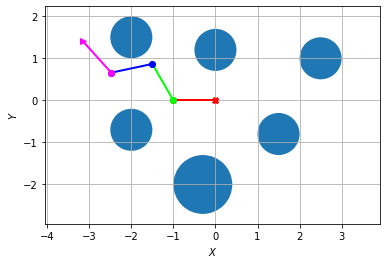

In [6]:
# Animation

# Figure set
fig = plt.figure()

# Define function to draw a frame
def frame(t):
    env_start.state = State(np.array(plan[t])) 
    plt.clf()
    return env_start.render(plt_title=None, plt_show=False)

# Save animation
anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
anime.save("test.gif", writer='PillowWriter', fps=10)

**B. Comment on how many states have been visited? What is the final trajectory size? Can you comment on the optimality of the plan? You can also collect some observations and statistics across multiple runs.**

**Comment: Average amount of visited states is 3000 nodes. It basically depends on randomness and random seed. Final trajectory size is also depend on random seed. But average is around 140. The path is non-optimal, because RRT does not solve this task. RRT_star is modification that is responsible for optimal path planning. Average computation time is 50sec, but it again depends on random seed. Sometimes it possible to get the result in 7 seconds.**

**C. Try to change weight of rotation in calculation of distance between two agent positions. We suggest you to build a distance function based on weighted sum of the angle distances. Comment on the results.**


In [7]:
# Define weights array
weights_1 = np.array([2, 1, 1, 1])
weights_2 = np.array([1, 2, 1, 1])
weights_3 = np.array([1, 1, 2, 1])
weights_4 = np.array([1, 1, 1, 2])
weights_list = [weights_1, weights_2, weights_3, weights_4]

for i in range(len(weights_list)):
    plan = find_path_RRT(start_state, goal_state, weights_angles=weights_list[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save("test.gif", writer='PillowWriter', fps=10)


RRT status: Failure
RRT status: Failure
RRT status: Failure
RRT status: Failure


**Comment: Increase of weights extended computational time and led to the algorithm failure in all changing cases.**

RRT status: Failure


MovieWriter PillowWriter unavailable; using Pillow instead.


-------------------------------
RRT status: Success
Amount of visited nodes:  3075
Plan length:  92
-------------------------------
RRT status: Failure
RRT status: Failure


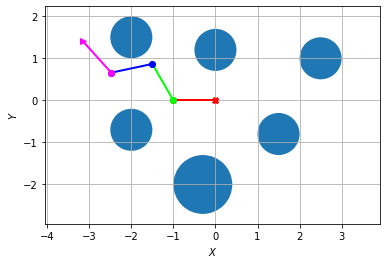

In [9]:
# Define weights array
weights_1 = np.array([0.5, 1, 1, 1])
weights_2 = np.array([1, 0.5, 1, 1])
weights_3 = np.array([1, 1, 0.5, 1])
weights_4 = np.array([1, 1, 1, 0.5])
weights_list = [weights_1, weights_2, weights_3, weights_4]


for i in range(len(weights_list)):
    plan = find_path_RRT(start_state, goal_state, weights_angles=weights_list[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save("test.gif", writer='PillowWriter', fps=10)

**Comment: Only decrease of $\theta_3$ led to successful result. And this result is a bit more optimal than original result (92 nodes 98 nodes, but amount of visited nodes was increased twicely).**

**D. Try to change step size used for RRT branches. Comment on the results.**

In [12]:
# Initialize list of max allowed ranges:
max_diff = [5, 15]

for i in range(len(max_diff)):
    plan = find_path_RRT(start_state, goal_state, max_difference=max_diff[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save(f"task2D_{i}.gif", writer='PillowWriter', fps=10)

RRT status: Failure
RRT status: Failure


**Comment: Unfortunately, change of the max possible angle rotation led to the failure in both cases for random seed 0.**

**Conclusion: RRT is a pretty slow and non-stable algorithm which is influenced by many factors, especially random seed. It is like the computer roll 4 dices simultaneously with infinity amount of dice faces. This is the main reason of instability. But in the end we can use it in continuos domain, where $A*$ or Djkstra could not be used.**